### Data Transfrom + Cropping-Script

In [35]:
import numpy as np
import os, sys, json
import PIL
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

img_dir = '../../rf-chess-data/roboflow/export/'
img_fns = os.listdir(img_dir)

annotate_fn = '_annotations.coco.json'

with open(Path(img_dir, annotate_fn), 'r') as f:
    d_annotate = json.load(f)

##### Data Merge + Transform `v1`

In [56]:
# original tables
df_annotate   = pd.DataFrame(d_annotate['annotations'])
df_images     = pd.DataFrame(d_annotate['images'])
df_categories = pd.DataFrame(d_annotate['categories'])

# merges + drop unnec cols
df_join = pd.merge(df_annotate, 
                   df_images,
                   how='left',
                   left_on='image_id',
                   right_on='id')

drop_cols = ["id_x","id_y", "license", 
             "segmentation", "iscrowd", "date_captured"]
df_join = df_join.drop(drop_cols, axis=1)

df_join = pd.merge(df_join,
                    df_categories,
                    how='left',
                    left_on='category_id',
                    right_on='id'
                   )

df_join = df_join.drop(["id", "supercategory"], axis=1)
df_join = df_join.rename(mapper={'name': 'category_full_name'}, axis=1)

# add extra cols
df_join['annotate_id'] = df_join.index

df_join['coord_tl'] = df_join['bbox'].map(lambda x: [x[0], x[1]])
df_join['coord_br'] = df_join['bbox'].map(lambda x: [x[0] + x[2], x[1] + x[3]])

df_join['category_color_name'] = df_join['category_full_name'].map(lambda x: x.split('-')[0])
df_join['category_piece_name'] = df_join['category_full_name'].map(lambda x: x.split('-')[1])

df_join.to_csv('meta-data/data_v1.csv', index=False)

In [58]:
df_join.head(3)

,image_id,category_id,bbox,area,file_name,height,width,category_full_name,annotate_id,coord_tl,coord_br,category_color_name,category_piece_name
0,0,10,"[959, 767, 107, 161]",17227,0301b7f9ed4d5ba503fda79fc4370c29.jpg,1529,2284,white-pawn,0,"[959, 767]","[1066, 928]",white,pawn
1,1,5,"[1127, 229, 129, 257]",33153,00bc0cacffdebe6b11bdeec56f63ee49.jpg,1529,2284,black-queen,1,"[1127, 229]","[1256, 486]",black,queen
2,2,4,"[1163, 614, 104, 154]",16016,03886821377011fec599e8fa12d86e89.jpg,1529,2284,black-pawn,2,"[1163, 614]","[1267, 768]",black,pawn


##### Demo Copping

In [61]:
N = 5
example_rows = df_join[df_join['image_id'] < N]
print(example_rows.shape)
example_rows.head(3)

(18, 13)


,image_id,category_id,bbox,area,file_name,height,width,category_full_name,annotate_id,coord_tl,coord_br,category_color_name,category_piece_name
0,0,10,"[959, 767, 107, 161]",17227,0301b7f9ed4d5ba503fda79fc4370c29.jpg,1529,2284,white-pawn,0,"[959, 767]","[1066, 928]",white,pawn
1,1,5,"[1127, 229, 129, 257]",33153,00bc0cacffdebe6b11bdeec56f63ee49.jpg,1529,2284,black-queen,1,"[1127, 229]","[1256, 486]",black,queen
2,2,4,"[1163, 614, 104, 154]",16016,03886821377011fec599e8fa12d86e89.jpg,1529,2284,black-pawn,2,"[1163, 614]","[1267, 768]",black,pawn


In [62]:
def load_np_img(img_fn):
    img_pil = PIL.Image.open(Path(img_dir, img_fn))
    img_np = np.array(img_pil)
    return img_np

def crop_img(img, bbox):
    lx, ly, w, h = bbox
    return img[ly:ly+h,lx:lx+w ,:] 

In [68]:
ann_ids, crop_imgs, class_names = [], [], []

for _i in range(len(example_rows)):
    
    _row = example_rows.iloc[_i,:]
    
    img = load_np_img(_row['file_name'])
    
    img_cropped = crop_img(img, _row['bbox'])
    
    ann_ids.append(_row['annotate_id'])
    crop_imgs.append(img_cropped)
    class_names.append(_row['category_full_name'])

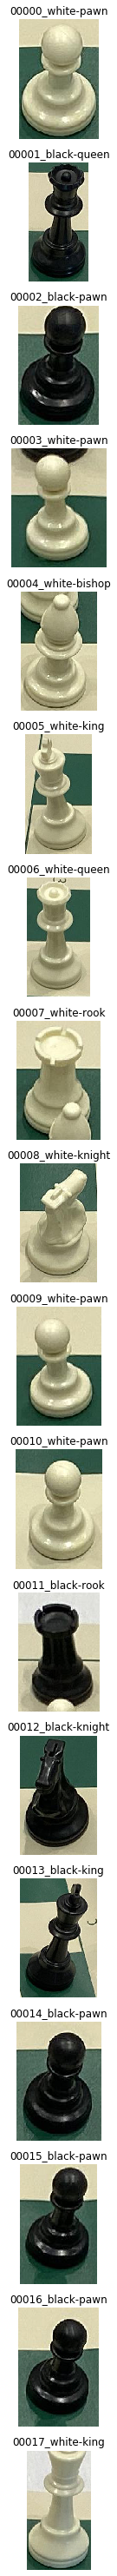

In [70]:
n = len(crop_imgs[:80])

fig, ax = plt.subplots(nrows=n, ncols=1, figsize=(6, n*3))

for _i, (_img, _catid, _annid) in enumerate(
                                    zip(crop_imgs,
                                        class_names,
                                        ann_ids)):
    ax[_i].imshow(_img)
    
    ax[_i].axis('off')
    
    title =  str(_annid).zfill(5)
    title += "_"
    title += _catid
    title += ".jpg"
    ax[_i].title.set_text(title)

In [77]:
# how to save
img = PIL.Image.fromarray(_img)
img.save('king.jpg')

##### Demo script

In [98]:
import numpy as np
from PIL import Image
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from ast import literal_eval

In [102]:
def load_np_img(img_fn):
    img_pil = PIL.Image.open(Path(img_dir, img_fn))
    img_np = np.array(img_pil)
    return img_np

def crop_img(img, bbox):
    lx, ly, w, h = bbox
    return img[ly:ly+h,lx:lx+w ,:] 

In [103]:
img_dir = Path('../../rf-chess-data/roboflow/export/')
save_dir = Path('../../rf-chess-data/cropped_v1')
meta_df = 'meta-data/data_v1.csv'

df = pd.read_csv(meta_df)
df['bbox'] = df['bbox'].map(lambda x: literal_eval(x))
df = df.iloc[:4,:]

for _i in range(len(df)):
    
    _row = df.iloc[_i,:]
    
    _img = load_np_img(_row['file_name'])
    
    _imgcropped = crop_img(_img, _row['bbox'])
    
    _annid = _row['annotate_id']
    _catid = _row['category_full_name']

    title =  str(_annid).zfill(5)
    title += "_"
    title += _catid
    title += ".jpg"

    _imgpil = PIL.Image.fromarray(_imgcropped)
    
    _imgpil.save(save_dir / title)